In [1]:
import pandas as pd
import numpy as np
import feather
import time
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import xgboost as xgb

from sklearn.metrics import silhouette_samples
from matplotlib import cm

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

/Users/mshogo/miniconda3/envs/kaggle/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Deprecation warning will be ignored!


In [4]:
count_df = pd.read_table('../data/luad_Merged_Counts.tsv')
feather.write_dataframe(count_df, '../data/luad_Counts.feather')
# fpkm_df = pd.read_table('../data/Merged_FPKM.tsv')
# feather.write_dataframe(count_df, '../data/adsc_fpkm.feather')
# fpkm_uq_df = pd.read_table('../data/Merged_FPKM-UQ.tsv')
# feather.write_dataframe(count_df, '../data/adsc_uq_fpkm.feather')

In [5]:
clinical_df = pd.read_table('../data/LUAD_clinicalMatrix', index_col=0)
clinical_columns_dict = {
    'sampleID': 'tcga_id',
#    '_primary_disease': 'primary',
#    'gender': 'gender',
#     'sample_type': 'tcga_type',
     'Expression_Subtype': 'exp_sub',
}
clinical_df = clinical_df.filter(items=clinical_columns_dict.keys())
clinical_df = clinical_df.rename(columns=clinical_columns_dict)
#clinical_df['primary'] = clinical_df['primary'].replace( {'lung adenocarcinoma': 'LUAD', 'lung squamous cell carcinoma': 'LUSC'} )
print(clinical_df.shape)
clinical_df.head()

(706, 1)


,exp_sub
sampleID,
TCGA-05-4244-01,NaN
TCGA-05-4249-01,Bronchioid
TCGA-05-4250-01,NaN
TCGA-05-4382-01,Squamoid
TCGA-05-4384-01,Bronchioid


In [6]:
adsc_raw_df = pd.read_feather('../data/luad_Counts.feather')
adsc_df = adsc_raw_df.drop(adsc_raw_df.iloc[-5:, :].index, axis=0)
adsc_df = adsc_df.rename(columns={'Unnamed: 0': 'geneID'})
adsc_df = adsc_df.drop(['gene_name'], axis=1).set_index('geneID')
adsc_df.columns = [name[:15] for name in adsc_df.columns]
adsc_df = adsc_df.T.groupby(level=0).last() 
print(adsc_df.shape)
adsc_df.head()

(574, 60483)


geneID,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000263980.4,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1
TCGA-05-4244-01,5027,0,1460,1500,867,1978,2983,4504,3129,3113,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4249-01,4415,0,2019,1891,519,1220,2758,3588,1582,6987,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4250-01,5355,5,2898,734,785,1484,4541,5274,2845,3697,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4382-01,3898,0,2832,1192,793,4687,8694,8710,5934,4073,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4384-01,1347,0,910,986,209,1053,1533,1696,6634,1272,...,0,0,0,0,0,0,0,0,0,0


In [138]:
def normalize(df):
    # 正規化
    mtx = MinMaxScaler().fit_transform(df.values)
    return pd.DataFrame(mtx, index=df.index, columns=df.columns)

def select_sample(df, clinic_df, rate):
    merge_df = pd.concat([df, clinic_df], axis=1, join_axes=[df.index])
    # nanの持つサブタイプはサンプルを削除
    merge_df = merge_df.dropna(subset=['exp_sub'])
    return merge_df.sample(frac=rate, random_state=23)

def select_gene(df, mad_num):
    # 0カウントが半分以上の遺伝子削除
    del_list = [name for name in list(df.columns) if df[name].isin([0]).sum() > int(df.shape[0]/2)]
    df.drop(del_list, axis=1, inplace=True)
    # 分散が大きい上位を選択
    mad_genes = df.mad(axis=0).sort_values(ascending=False)
    top_mad_genes = mad_genes.iloc[0:mad_num, ].index
    return df.loc[:, top_mad_genes]

def evaluate(df):
    test_df = df['exp_sub'].map({'Bronchioid': 0, 'Squamoid': 1, 'Magnoid': 2})
    train_df = df.drop(['exp_sub'], axis=1)
    xgb.XGBRegressor().fit(train_df.values, test_df.values)
    indice = np.argsort(model.feature_importances_)[::-1]
    indice = indice[:50]
    plt.subplots(figsize=(10, 20))
    plt.subplot(3, 1, 1)
    g = sns.barplot(y=df.columns[indice], x=model.feature_importances_[indice], orient='h')
    g.set_xlabel('Relative importance', fontsize=12)
    g.set_ylabel('Features', fontsize=12)
    g.tick_params(labelsize=6)
    g.set_title('XGB feature importance');
    
    sss = StratifiedShuffleSplit(test_df, 10, test_size=0.2, random_state=23)
    for train_index, test_index in sss:
        X_train, X_test = train_df.values[train_index], train_df.values[test_index]
        y_train, y_test = test_df[train_index], test_df[test_index]
        
    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="rbf", C=0.025, probability=True),
        NuSVC(probability=True),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        GaussianNB(),
        LinearDiscriminantAnalysis(),
        QuadraticDiscriminantAnalysis(),
        xgb.XGBClassifier()]

    # Logging for Visual Comparison
    log_cols=["Classifier", "Accuracy", "Log Loss"]
    log = pd.DataFrame(columns=log_cols)

    for clf in classifiers:
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__

        print("="*30)
        print(name)

        print('****Results****')
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        print("Accuracy: {:.4%}".format(acc))

        train_predictions = clf.predict_proba(X_test)
        ll = log_loss(y_test, train_predictions)
        print("Log Loss: {}".format(ll))

        log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
        log = log.append(log_entry)

    print("="*30)
    
    plt.subplot(3, 1, 2)
    sns.set_color_codes("muted")
    sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
    plt.xlabel('Accuracy %')
    plt.title('Classifier Accuracy')
    
    plt.subplot(3, 1, 3)
    sns.set_color_codes("muted")
    sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

    plt.xlabel('Log Loss')
    plt.title('Classifier Log Loss')
    return log

In [139]:
def classify_adsc(df, clinic_df,mad_num, rate):
    normalized_df = normalize(df)
    gene_selected_df = select_gene(normalized_df, mad_num)
    post_preprocessing_df = select_sample(gene_selected_df, clinic_df, rate)
    log = evaluate(post_preprocessing_df)
    return log

# 値全体補正 + 列選択
### 1.値全体補正：MinMaxScaler
### 2.列選択 : geneごとに値が0の場合、半分以上を削除、MAD上位10000

KNeighborsClassifier
****Results****
Accuracy: 33.3333%
Log Loss: 12.014284597228984
SVC
****Results****
Accuracy: 50.0000%
Log Loss: 1.0875209347182924
NuSVC
****Results****
Accuracy: 33.3333%
Log Loss: 1.0269160526649914
DecisionTreeClassifier
****Results****
Accuracy: 16.6667%
Log Loss: 28.78231366242557
RandomForestClassifier
****Results****
Accuracy: 50.0000%
Log Loss: 1.0053810902713731
AdaBoostClassifier
****Results****
Accuracy: 33.3333%
Log Loss: 6.892631126678002
GradientBoostingClassifier
****Results****
Accuracy: 66.6667%
Log Loss: 2.3400117874081903
GaussianNB
****Results****
Accuracy: 50.0000%
Log Loss: 17.269388197455342
LinearDiscriminantAnalysis
****Results****
Accuracy: 16.6667%
Log Loss: 1.4201571454567494
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 0.0000%
Log Loss: 34.538776394910684
XGBClassifier
****Results****
Accuracy: 50.0000%
Log Loss: 1.0200053006410599
経過時間：26.835165977478027


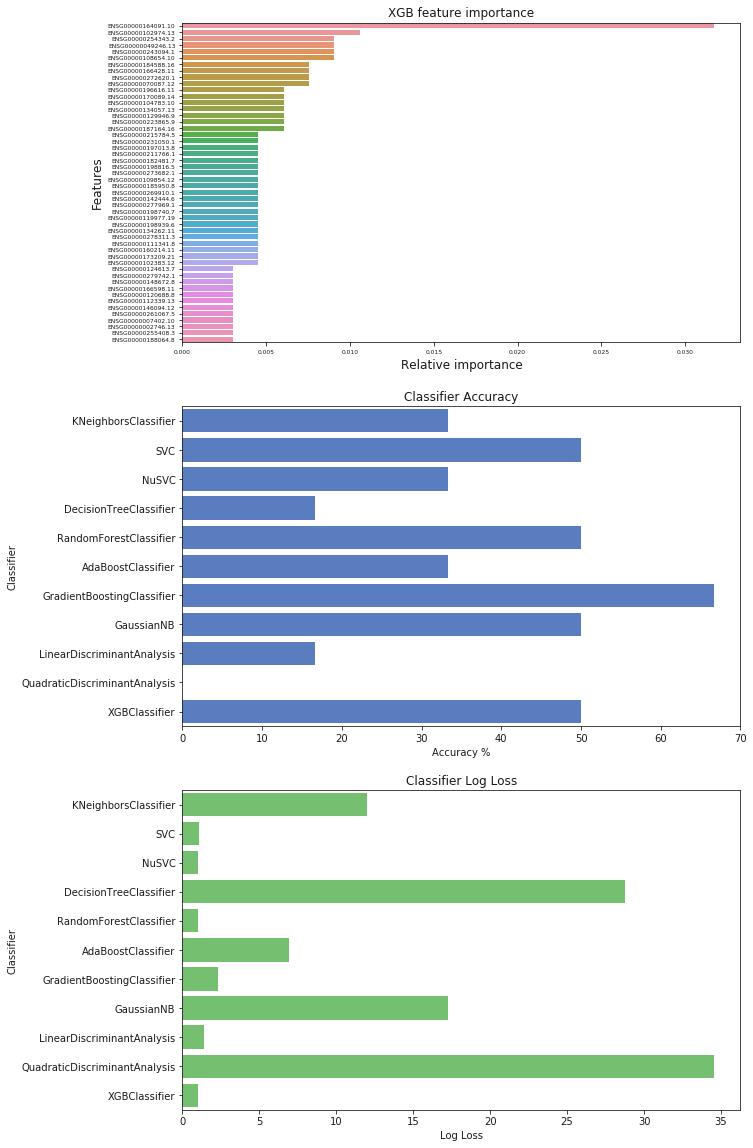

In [142]:
# 処理前の時刻
t1 = time.time() 
log_01_df = classify_adsc(adsc_df, clinical_df, 10000, 0.1)
# 処理後の時刻
t2 = time.time()
print("経過時間：{}".format(t2-t1))

KNeighborsClassifier
****Results****
Accuracy: 54.5455%
Log Loss: 12.770010290239576
SVC
****Results****
Accuracy: 36.3636%
Log Loss: 1.1176830702166598
NuSVC
****Results****
Accuracy: 63.6364%
Log Loss: 0.9877747327127271
DecisionTreeClassifier
****Results****
Accuracy: 36.3636%
Log Loss: 21.97922134221589
RandomForestClassifier
****Results****
Accuracy: 54.5455%
Log Loss: 6.867609446734499
AdaBoostClassifier
****Results****
Accuracy: 45.4545%
Log Loss: 7.067886936129522
GradientBoostingClassifier
****Results****
Accuracy: 45.4545%
Log Loss: 3.0741433472843203
GaussianNB
****Results****
Accuracy: 45.4545%
Log Loss: 18.839332579042193
LinearDiscriminantAnalysis
****Results****
Accuracy: 72.7273%
Log Loss: 1.0428460274808424
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 36.3636%
Log Loss: 21.97922134221589
XGBClassifier
****Results****
Accuracy: 45.4545%
Log Loss: 1.2087983824312687
経過時間：34.41098713874817


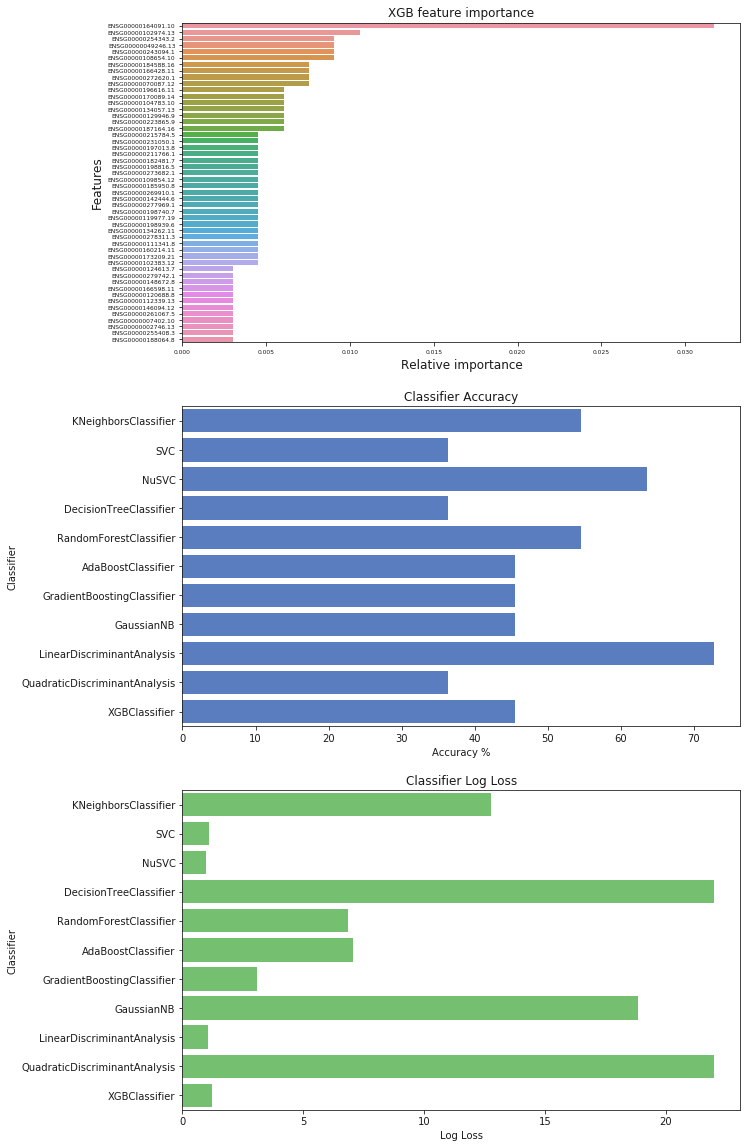

In [143]:
# 処理前の時刻
t1 = time.time() 
log_01_df = classify_adsc(adsc_df, clinical_df, 10000, 0.2)
# 処理後の時刻
t2 = time.time()
print("経過時間：{}".format(t2-t1))

KNeighborsClassifier
****Results****
Accuracy: 39.2857%
Log Loss: 10.35167527608114
SVC
****Results****
Accuracy: 39.2857%
Log Loss: 1.0057302876001235
NuSVC
****Results****
Accuracy: 57.1429%
Log Loss: 0.9599653988568251
DecisionTreeClassifier
****Results****
Accuracy: 50.0000%
Log Loss: 17.26938819745534
RandomForestClassifier
****Results****
Accuracy: 32.1429%
Log Loss: 1.102789586892437
AdaBoostClassifier
****Results****
Accuracy: 42.8571%
Log Loss: 1.0764961005661617
GradientBoostingClassifier
****Results****
Accuracy: 53.5714%
Log Loss: 1.729637184605967
GaussianNB
****Results****
Accuracy: 42.8571%
Log Loss: 19.736443654235778
LinearDiscriminantAnalysis
****Results****
Accuracy: 60.7143%
Log Loss: 1.09243455257452
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 28.5714%
Log Loss: 24.670554567793342
XGBClassifier
****Results****
Accuracy: 57.1429%
Log Loss: 0.9420898143601205
経過時間：64.23653101921082


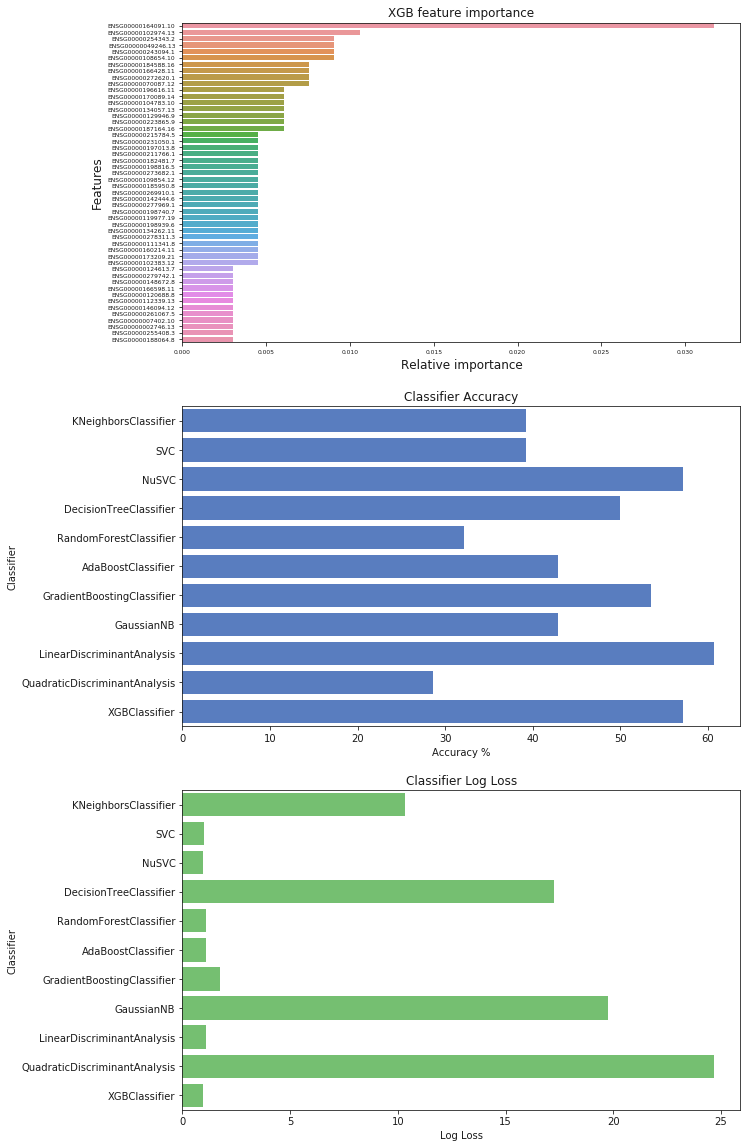

In [144]:
# 処理前の時刻
t1 = time.time() 
log_01_df = classify_adsc(adsc_df, clinical_df, 10000, 0.5)
# 処理後の時刻
t2 = time.time()
print("経過時間：{}".format(t2-t1))